# Audio Classification with Computer Vision

> The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50) is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.
>
> The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.lib import stride_tricks
import os
import pandas as pd
import scipy.io.wavfile as wav

## Visualize the Dataset

In [45]:
esc50_df = pd.read_csv('dataset/ESC-50/esc50.csv')
esc50_df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [60]:
esc50_df['category'].value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

In [11]:
def fourier_transformation(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames) 

In [12]:
def make_logscale(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

In [13]:
def plot_spectrogram(location, categorie, plotpath=None, binsize=2**10, colormap="jet"):
    samplerate, samples = wav.read(location)

    s = fourier_transformation(samples, binsize)

    sshow, freq = make_logscale(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.title('Class Label: ' + categorie)
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()

    return ims

timebins:  431
freqbins:  513


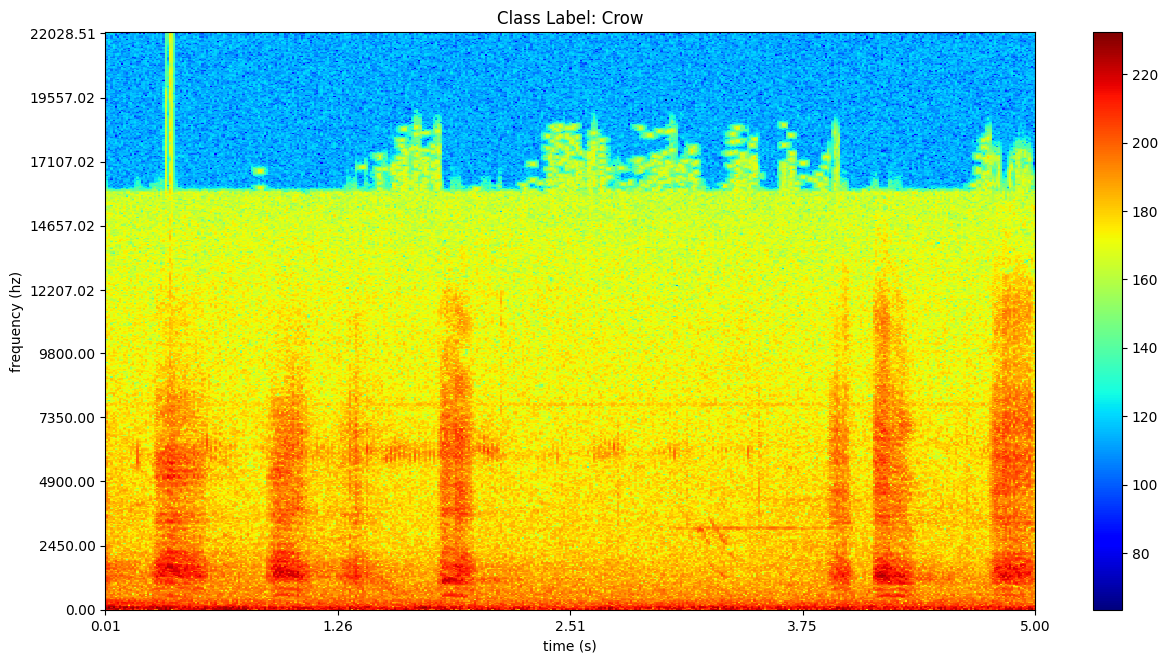

<Figure size 640x480 with 0 Axes>

In [57]:
plot = plot_spectrogram('dataset/ESC-50/audio/' + esc50_df[esc50_df['category'] == 'crow']['filename'].iloc[0], categorie='Crow')

timebins:  431
freqbins:  513


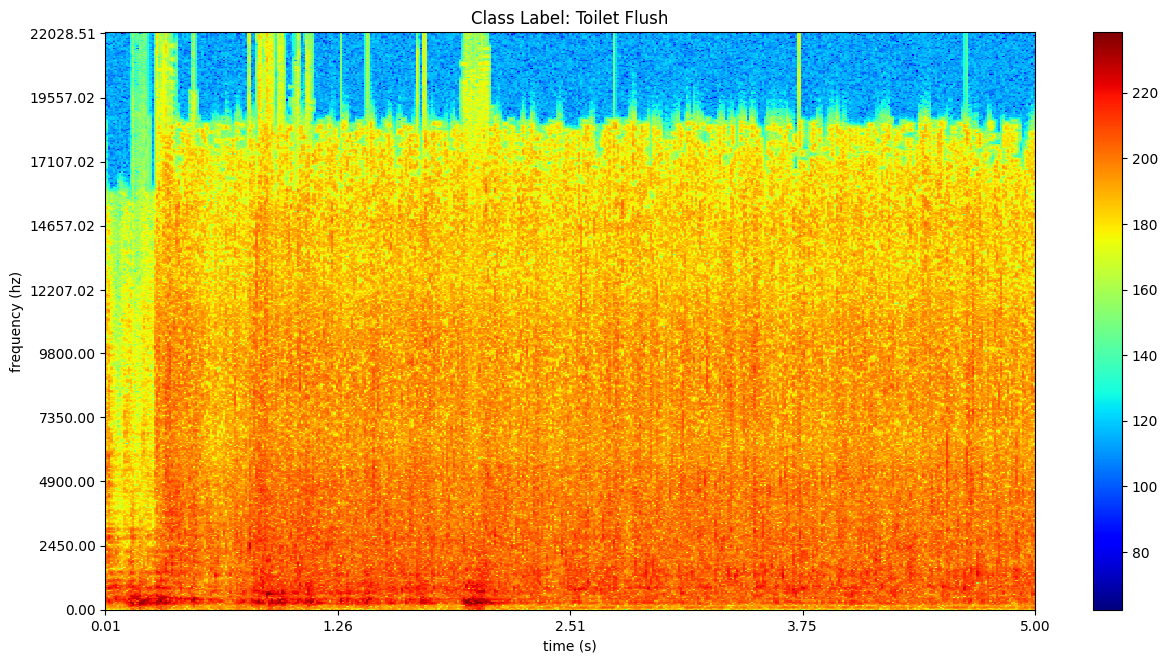

<Figure size 640x480 with 0 Axes>

In [58]:
plot = plot_spectrogram('dataset/ESC-50/audio/' + esc50_df[esc50_df['category'] == 'toilet_flush']['filename'].iloc[0], categorie='Toilet Flush')

## Data Preprocessing

In [101]:
def audio_vis(location, filepath, binsize=2**10, colormap="jet"):
    samplerate, samples = wav.read(location)

    s = fourier_transformation(samples, binsize)

    sshow, freq = make_logscale(s, factor=1.0, sr=samplerate)

    with np.errstate(divide='ignore'):
        ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")

    plt.axis('off')
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])
    
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()

    return

In [102]:
conversion = []

for i in range(len(esc50_df.index)):
    
    filename = esc50_df['filename'].iloc[i]
    location = 'dataset/ESC-50/audio/' + filename
    category = esc50_df['category'].iloc[i]
    catpath = 'dataset/ESC-50/spectrogram/' + category
    filepath = catpath + '/' + filename[:-4] + '.jpg'

    conversion.append({location, filepath})

In [104]:
conversion[0]

{'dataset/ESC-50/audio/1-100032-A-0.wav',
 'dataset/ESC-50/spectrogram/dog/1-100032-A-0.jpg'}

In [105]:
for i in range(len(esc50_df.index)):
    
    filename = esc50_df['filename'].iloc[i]
    location = 'dataset/ESC-50/audio/' + filename
    category = esc50_df['category'].iloc[i]
    catpath = 'dataset/ESC-50/spectrogram/' + category
    filepath = catpath + '/' + filename[:-4] + '.jpg'

    os.makedirs(catpath, exist_ok=True)
    
    audio_vis(location, filepath)

### Train-Test-Split

In [1]:
!pip install split-folders

In [5]:
import splitfolders

In [6]:
input_folder = 'dataset/ESC-50/spectrogram'
output = 'data'

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 2000 files [00:34, 57.19 files/s] 


### Prepare Validation Data

In [1]:
testing = [
    'data/test/helicopter.wav',
    'data/test/cat.wav'
]

In [9]:
def test_vis(location, filepath, binsize=2**10, colormap="jet"):
    samplerate, samples = wav.read(location)

    s = fourier_transformation(samples, binsize)

    sshow, freq = make_logscale(s, factor=1.0, sr=samplerate)

    with np.errstate(divide='ignore'):
        ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")

    plt.axis('off')
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])
    
    plt.savefig(filepath, bbox_inches="tight")
    plt.close()

    return

In [14]:
test_vis(testing[0], filepath='data/test/helicopter.jpg')

In [15]:
test_vis(testing[1], filepath='data/test/cat.jpg')